In [2]:
import trackhhl.toy.simple_generator as toy
import numpy as np

### Detector Geometry

In [3]:
N_MODULES = 3
LX = float("+inf")
LY = float("+inf")
Z_SPACING = 1.0

detector = toy.SimpleDetectorGeometry(
    module_id=list(range(N_MODULES)),
    lx=[LX]*N_MODULES,
    ly=[LY]*N_MODULES,
    z=[i+Z_SPACING for i in range(N_MODULES)]
)

detector

SimpleDetectorGeometry(module_id=[0, 1, 2], lx=[inf, inf, inf], ly=[inf, inf, inf], z=[1.0, 2.0, 3.0])

### Particle Generator


In [4]:
generator = toy.SimpleGenerator(
    detector_geometry=detector,
    theta_max=np.pi/6
)
generator

SimpleGenerator(detector_geometry=SimpleDetectorGeometry(module_id=[0, 1, 2], lx=[inf, inf, inf], ly=[inf, inf, inf], z=[1.0, 2.0, 3.0]), primary_vertices=[], phi_min=0.0, phi_max=6.283185307179586, theta_min=0.0, theta_max=0.5235987755982988, rng=Generator(PCG64) at 0x296FC3AB140)

In [5]:
N_PARTICLES = 3
event = generator.generate_event(N_PARTICLES)
event.hits

[Hit(hit_id=0, x=-0.23763960898404773, y=-0.4802383525946568, z=1.0, module_id=0, track_id=0),
 Hit(hit_id=3, x=0.1884231865151258, y=-0.2404090239705377, z=1.0, module_id=0, track_id=1),
 Hit(hit_id=6, x=-0.032514547888459, y=-0.3981218807810384, z=1.0, module_id=0, track_id=2),
 Hit(hit_id=1, x=-0.47527921796809547, y=-0.9604767051893136, z=2.0, module_id=1, track_id=0),
 Hit(hit_id=4, x=0.3768463730302516, y=-0.4808180479410754, z=2.0, module_id=1, track_id=1),
 Hit(hit_id=7, x=-0.065029095776918, y=-0.7962437615620768, z=2.0, module_id=1, track_id=2),
 Hit(hit_id=2, x=-0.7129188269521431, y=-1.4407150577839705, z=3.0, module_id=2, track_id=0),
 Hit(hit_id=5, x=0.5652695595453774, y=-0.7212270719116132, z=3.0, module_id=2, track_id=1),
 Hit(hit_id=8, x=-0.09754364366537699, y=-1.194365642343115, z=3.0, module_id=2, track_id=2)]

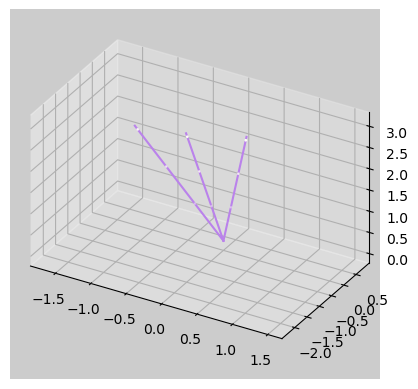

In [6]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
# Create a 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
event.display(ax)
plt.show()

In [12]:
import numpy as np

events = [np.array([hit.x, hit.y, hit.z]) for hit in event.hits]
N_hits = len(events)
epsilon = 0.01

def H_angular(event_hits, epsilon):
    h_ang = 0
    N_hits = len(event_hits) 

    for a in range(N_hits):
        for b in range(N_hits):
            if a == b:
                continue
            for c in range(N_hits):
                if b == c or a == c:
                    continue

                S_ab = event_hits[b] - event_hits[a]
                S_bc = event_hits[c] - event_hits[b]
                length_ab = np.linalg.norm(S_ab)
                length_bc = np.linalg.norm(S_bc)

                if length_ab == 0 or length_bc == 0:
                    continue

                cos_theta_abc = np.dot(S_ab, S_bc) / (length_ab * length_bc)
                if cos_theta_abc >= 1 - epsilon:
                    h_ang -= 0.5  

    return h_ang

def H_bif(event_hits):
    h_bif = 0
    N_hits = len(event_hits)
#first sum
    for a in range(N_hits):
        for b in range(N_hits):
            if a == b:
                continue
            for c in range(N_hits):
                if a == c or b == c:
                    continue

                S_ab = event_hits[b] - event_hits[a]
                S_ac = event_hits[c] - event_hits[a]

                h_bif += np.dot(S_ab, S_ac)
#second sum
    for b in range(N_hits):
        for a in range(N_hits):
            if a == b:
                continue
            for c in range(N_hits):
                if b == c or a == c:
                    continue

                S_ab = event_hits[b] - event_hits[a]
                S_bc = event_hits[c] - event_hits[b]

                h_bif += np.dot(S_ab, S_bc)

    h_bif *= 0.5
    return h_bif


def H_occ(event_hits):
    N_hits = len(event_hits)
    total_sum = 0
    for a in range(N_hits):
        for b in range(N_hits):
            if a == b:
                continue

            S_ab = event_hits[b] - event_hits[a]
            total_sum += np.linalg.norm(S_ab)

    h_occ = 0.5 * (total_sum - N_hits) ** 2

    return h_occ

def HAMILTONIAN(events, epsilon):
    h_angular_value = H_angular(events, epsilon)
    h_bif_value = H_bif(events)
    h_occ_value = H_occ(events)
    return h_angular_value + h_bif_value + h_occ_value

print(f"Hamiltonian (angular term): {h_angular_value}")
print(f"Hamiltonian (bifurcation term): {h_bif_value}")
print(f"Hamiltonian (occupancy term): {h_occ_value}")
print(HAMILTONIAN(events,epsilon))




Hamiltonian (angular term): -3.0
Hamiltonian (bifurcation term): 1.2884138200774942e-13
Hamiltonian (occupancy term): 3734.8009528734715
3731.8009528734715
